# MODELO TIME SERIES ORDER SERIES

Cargar datos y disponibilidad de datos en fechas

In [1]:
import pandas as pd

# Cargar el archivo
file_path = './data/orders_orders.xlsx'
data = pd.read_excel(file_path)

# Ver rango de fechas
print("Rango de fechas:", data['Order Date'].min(), "a", data['Order Date'].max())


Rango de fechas: 2011-01-01 00:00:00 a 2014-12-31 00:00:00


Sumar cifra diaria y escoger las columnas que utilizaremos para el timeseries modelling

Separación de los dos datasets (train y test) por los años 2011-2013 para el train y 2014 para el test

In [2]:
# Asegurarse de que las fechas estén ordenadas
data = data.sort_values('Order Date')

# Agregar ventas diarias
daily_sales = data.groupby('Order Date')['Sales'].sum().reset_index()

# Dividir en train y test
train = daily_sales[(daily_sales['Order Date'] >= '2011-01-01') & (daily_sales['Order Date'] <= '2013-12-31')]
test = daily_sales[(daily_sales['Order Date'] >= '2014-01-01') & (daily_sales['Order Date'] <= '2014-12-31')]

print("Train:", train['Order Date'].min(), "a", train['Order Date'].max())
print("Test:", test['Order Date'].min(), "a", test['Order Date'].max())


Train: 2011-01-01 00:00:00 a 2013-12-31 00:00:00
Test: 2014-01-01 00:00:00 a 2014-12-31 00:00:00


Exploracion visual de los datos

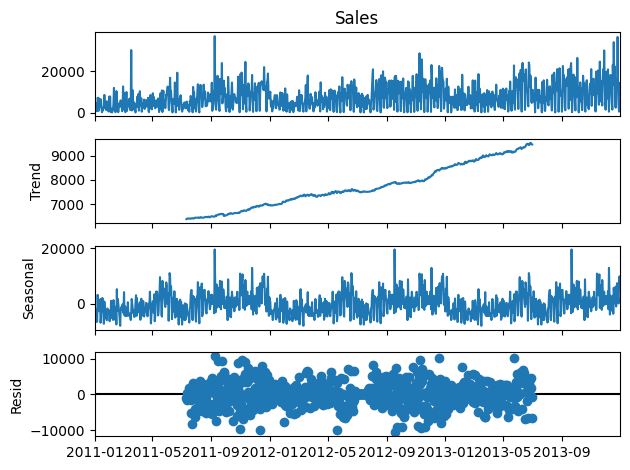

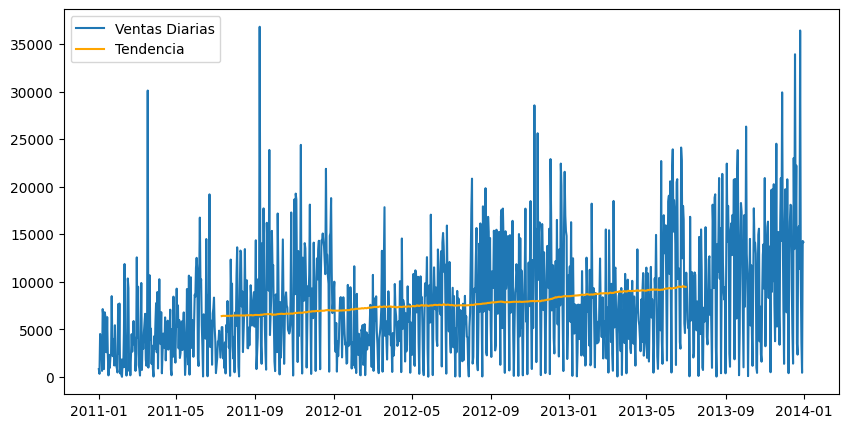

In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Configuración de índice temporal
train.set_index('Order Date', inplace=True)

# Descomposición de la serie
decompose_result = seasonal_decompose(train['Sales'], model='additive', period=365)

# Gráficos de descomposición
decompose_result.plot()
plt.show()

# Visualización adicional de la tendencia
plt.figure(figsize=(10, 5))
plt.plot(train['Sales'], label='Ventas Diarias')
plt.plot(decompose_result.trend, label='Tendencia', color='orange')
plt.legend()
plt.show()


Prueba de test AdFuller o ADF para detectar estacionalidad en los datos tanto de train como de test

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title=""):
    result = adfuller(series.dropna())
    print(f'{title} ADF Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:', result[4])

# Prueba para train y test
test_stationarity(train['Sales'], "Train")
test_stationarity(test.set_index('Order Date')['Sales'], "Test")


Train ADF Test Statistic: -3.2858857408160698
p-value: 0.015521291890962964
Critical Values: {'1%': -3.436617132314828, '5%': -2.864307097893787, '10%': -2.568243313067353}
Test ADF Test Statistic: -1.7731849449769657
p-value: 0.3938535201782304
Critical Values: {'1%': -3.4495033946549123, '5%': -2.8699787979596136, '10%': -2.5712658305164955}


Viendo esto, transformamos los datos de test para hacerlos estacionarios

In [5]:
test['Sales_diff'] = test['Sales'] - test['Sales'].shift(1)


C:\Users\Guillem\AppData\Local\Temp\ipykernel_18124\968162255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Sales_diff'] = test['Sales'] - test['Sales'].shift(1)


In [6]:
from statsmodels.tsa.stattools import adfuller
test_stationarity(test['Sales_diff'].dropna(), "Test Diferenciado")


Test Diferenciado ADF Test Statistic: -6.456410650022443
p-value: 1.4796592116827303e-08
Critical Values: {'1%': -3.4494474563375737, '5%': -2.8699542285903887, '10%': -2.5712527305187987}


Aplicamos la transformacion tambien a train para que tengan los mismos valores igualados

In [7]:
train['Sales_diff'] = train['Sales'] - train['Sales'].shift(1)


C:\Users\Guillem\AppData\Local\Temp\ipykernel_18124\2872338410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sales_diff'] = train['Sales'] - train['Sales'].shift(1)


In [9]:
from statsmodels.tsa.stattools import adfuller
test_stationarity(train['Sales_diff'].dropna(), "Train Diferenciado")

Train Diferenciado ADF Test Statistic: -9.07896892106044
p-value: 4.1053460922598114e-15
Critical Values: {'1%': -3.436617132314828, '5%': -2.864307097893787, '10%': -2.568243313067353}


Una vez los datos de train y test son estacionarios el modelo obvio que deberia funcionar mejor es el de SARIMA. No obstante, entrenamos el modelo ARIMA también

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Modelo ARIMA en datos diferenciados de Train
arima_model = ARIMA(train['Sales_diff'].dropna(), order=(1, 1, 1)).fit()

# Predicciones en Test (diferenciado)
arima_forecast_diff = arima_model.forecast(steps=len(test['Sales_diff'].dropna()))

# Reintegración de las predicciones a la escala original
arima_forecast = arima_forecast_diff.cumsum() + train['Sales'].iloc[-1]


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported inde

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modelo SARIMA en datos diferenciados de Train
sarima_model = SARIMAX(train['Sales_diff'].dropna(), 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 365)).fit()

# Predicciones en Test (diferenciado)
sarima_forecast_diff = sarima_model.forecast(steps=len(test['Sales_diff'].dropna()))

# Reintegración de las predicciones a la escala original
sarima_forecast = sarima_forecast_diff.cumsum() + train['Sales'].iloc[-1]


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


KeyboardInterrupt: 

Con métricas analizamos el funcionamiento del modelo

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluación para ARIMA
arima_rmse = np.sqrt(mean_squared_error(test['Sales'], arima_forecast))
arima_mae = mean_absolute_error(test['Sales'], arima_forecast)

# Evaluación para SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))
sarima_mae = mean_absolute_error(test['Sales'], sarima_forecast)

print("ARIMA - RMSE:", arima_rmse, "MAE:", arima_mae)
print("SARIMA - RMSE:", sarima_rmse, "MAE:", sarima_mae)


Planteamos la predicción con datos que no existen que sería el año 2015 y los enfrentamos a los de 2014

In [ ]:
# Predicciones para 2015 (365 días)
sarima_2015_forecast_diff = sarima_model.get_forecast(steps=365).predicted_mean

# Reintegrar predicciones a la escala original
sarima_2015_forecast = sarima_2015_forecast_diff.cumsum() + train['Sales'].iloc[-1]

# Visualización de las predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test['Order Date'], test['Sales'], label='Datos Reales (2014)')
plt.plot(test['Order Date'], sarima_forecast, label='Predicciones (2014)')
plt.plot(pd.date_range('2015-01-01', periods=365), sarima_2015_forecast, label='Predicciones (2015)', color='orange')
plt.legend()
plt.show()


Buscamos hacer una validación cruzada con Gridsearch para ver los parametros que nos da para mejorar el modelo

In [ ]:
from pmdarima import auto_arima

# GridSearch para SARIMA
auto_model = auto_arima(train['Sales_diff'].dropna(), 
                        seasonal=True, m=365, 
                        trace=True, error_action='ignore', 
                        suppress_warnings=True, stepwise=True)

print("Mejores parámetros SARIMA:")
print("Order:", auto_model.order)
print("Seasonal Order:", auto_model.seasonal_order)


Volvemos a entrenar el modelo con los parámetros que nos ha dado el gridsearch

In [ ]:
# Retrain con los mejores parámetros encontrados
best_sarima_model = SARIMAX(train['Sales_diff'].dropna(),
                            order=auto_model.order, 
                            seasonal_order=auto_model.seasonal_order).fit()

# Predicciones en Test
best_sarima_forecast_diff = best_sarima_model.forecast(steps=len(test['Sales_diff'].dropna()))
best_sarima_forecast = best_sarima_forecast_diff.cumsum() + train['Sales'].iloc[-1]


Reevaluamos y vemos como funciona el modelo optimizado con los parámetros que nos ha dado el Gridsearch

In [ ]:
# Evaluación del modelo optimizado
best_sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], best_sarima_forecast))
best_sarima_mae = mean_absolute_error(test['Sales'], best_sarima_forecast)

print("SARIMA Optimizado - RMSE:", best_sarima_rmse, "MAE:", best_sarima_mae)
